# EDA - Identifying Gas Station Chains Suitable for Marketing a Fueling App

## Background

The client, a navigation app, want to know about customer behavior at gas stations. They asked to figure out how much time, on average, drivers spend filling up at each gas station chain.

## Goal

The working hypothesis is that gas station chains with longest refueling times are appropriate to market a new fueling app; thus, the overall goal is to find chains with longest refueling visit times. Having said this, we should be careful and watch for anomalies in the visit time variable values and, to better estimate average visit time per chain, we will have to find those anomalies and address them appropriately.

## Content <a id='content'></a>

[Dataset](#dataset)

[Project stages](#steps)

[Data overview](#data_overview)

[Data preprocessing](#preprocessing)

[EDA](#eda)

[Estimating the median visit time per chain](#estimates)

[Summary and conclusions](#conclusions)

## Dataset <a id='dataset'></a>

We were provided with the data on individual gas station visits. The dataset contains the following variables:

- `name` — the encrypted name of each gas station chain; each name has been replaced with that of a flower
- `id` — a unique code for each particular gas station
- `date_time` — the time the driver arrived at the gas station, in ISO format;
- `time_spent` — the amount of time spent at the gas station in seconds.

Note: our dataset uses UTC time, while the time zone at the physical locations of our gas stations is North American Pacific Daylight Time (PDT).

## Project Stages <a id='steps'></a>

We were not provided with any previous information about the quality of the data, so exploring it will be our initial task. First, we evaluate the quality of the data and see how significant its issues are and what are appropriate ways to deal with them. We will remember that all kinds of issues can arise with the data:
- Incomplete or inaccurate data
- Mistakes in the recording of time values
- Seconds getting mixed up with minutes
- Major artifacts can find their way into the data which will require additional thought: closed gas stations, etc.

The next stage is to perform Exploratory Data Analysis to account for the anomalies in the data and be able to derive a robust estimate of the average visit time per chain at the following stage. The last stage is making an overview of the findings and writing recommendations. Thus, the project will consist of four stages:
 1. Data overview;
 2. Data preprocessing;
 3. EDA;
 4. Estimating the median visit time per chain;
 5. Summary and conclusion.
 
 [Back to Content](#content)

## Stage 1. Data Overview <a id='data_overview'></a>

### Opening of the data file and having a look at the general information  <a id='data_overview_general'></a>

We start with importing the necessary libraries and loading the data. If additional libraries are needed, we will add them to the next cell also and update it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt # We will need this for visualisations
%matplotlib inline
import seaborn as sns
from scipy import stats # We will need this in case we want to make some statistical checks
import warnings
warnings.filterwarnings("ignore") # To filter out automatic comments on plots from Jupyter (not affecting the output)

Let's read the data. We wrap the file reading request into a try-except block to make sure that the project runs both locally and on the platform and check that the data set was uploaded.

In [2]:
try:
    data = pd.read_csv('datasets/visits_eng.csv')
except:
    data = pd.read_csv('/datasets/visits_eng.csv')

# checking that the file was read

data.head(1)

,date_time\tid\ttime_spent\tname
0,20180407T025358\t76144fb2\t98.0\tCornflower


The data is piled into a single string instead of being neatly stored in different columns. Let's try once again.

In [3]:
try:
    data = pd.read_csv('datasets/visits_eng.csv', sep = '\t')
except:
    data = pd.read_csv('/datasets/visits_eng.csv', sep = '\t')

# checking that the file was read

data.head(1)

,date_time,id,time_spent,name
0,20180407T025358,76144fb2,98.0,Cornflower


The columns look neat, but let's check the info.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317104 entries, 0 to 317103
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date_time   317104 non-null  object 
 1   id          317104 non-null  object 
 2   time_spent  317104 non-null  float64
 3   name        317104 non-null  object 
dtypes: float64(1), object(3)
memory usage: 9.7+ MB


No missing values, perfect. `date_time` is a of the string type, but we are not bothered by it so far. The main numerical value, `time_spent`, is of the right type. Let's start from taking a look at the average `time_spent` per gas station chain (`name`). 

In [5]:
name_stat = pd.pivot_table(data = data, index = 'name', values = 'time_spent')
name_stat

,time_spent
name,
Ageratum,337.802721
Amaranth,132.760012
Ammobium,256.708042
Arctotis,73.879984
Astilba,376.143149
Balsam,134.508411
Begonia,163.200647
Bell,119.131564
Calendula,207.357323


We can see chains with average time spent of about 70 seconds, which looks a bit low. Let's answer several basic questions. We have already seen that the number of visits equals 317104, but let's print it out in a neat way.
1. How many visits are we working with?

In [6]:
total_visits = len(data) # number of gas station visits
print('Number of visits:', total_visits)

Number of visits: 317104


2. How many gas stations are we working with?

In [7]:
total_stations = len(data['id'].unique()) # number of gas stations
print('Number of gas stations:', total_stations) # print

Number of gas stations: 471


3. How many gas chains are we working with?

In [8]:
total_chains = len(data['name'].unique()) # number of gas chains
print('Number of gas chains:', total_chains) # print

Number of gas chains: 45


4. What time period does our data cover?

In [9]:
print(data['date_time'].min(), data['date_time'].max())

20180402T100008 20180409T100009


Thus, `total_days` equals 7:

In [10]:
total_days = 7

5. What is the average number of visits per gas station per day?

In [11]:
station_visits_per_day = total_visits / total_stations / total_days # number of visits per gas station per day
print('Number of visits per gas station per day:', station_visits_per_day)

Number of visits per gas station per day: 96.17955717318775


There is roughly 100 visits per day on average per a gas station, covered by the data. We shoud take into account that we are looking at the visits registared by a navigation app, not the native data of the gas stations, so visitors must have the app open during their visit at the gas station in order to be registered by the app. If we assume that about 50% of people entering a gas station have their navigation apps open and about 20% of them use this particular app, we come up with about 1000 visits on average per a gas station per day, which makes 40 to 50 visits on average per hour, which in turn makes sense if take into account the fueling time (a common sense estimation would be 2 to 3 minutes neto) and the fact that there are several fuel points on each station. Makes sense.

OK, let's move to a more complex one:

6.  How are visits distributed across chains over the 7-day period?

In [12]:
print(data['name'].value_counts().head(10)) # TOP 10 chains

Calendula       85648
Cornflower      79006
Dahlia          34356
Nemesia         20138
Bell            18835
Mallow          17386
Geyher          14125
Doroteanthus     6312
Narcissus        3640
Amaranth         3221
Name: name, dtype: int64


Ideally, we would have to consult experts, but we will assume that these are indeed the most popular gas chains. let's make a quick check on percentages.

In [13]:
print(data['name'].value_counts().head(10)/total_visits) # TOP 10 chains

Calendula       0.270094
Cornflower      0.249149
Dahlia          0.108343
Nemesia         0.063506
Bell            0.059397
Mallow          0.054827
Geyher          0.044544
Doroteanthus    0.019905
Narcissus       0.011479
Amaranth        0.010158
Name: name, dtype: float64


Two chains are especially popular with above 50% of the market share, looks matching the reality. To make sure we do not have any surprises, let's check the distribution visually, using a bar chart.

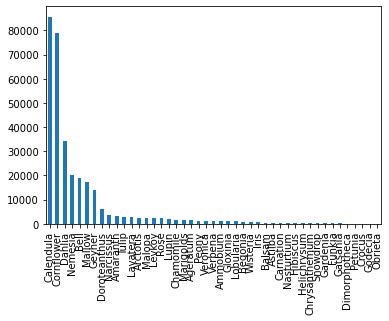

In [14]:
data['name'].value_counts().plot(kind='bar')
plt.show()

One can note  that less popular chains aren't visible at all, since they have very few values. Thus, in the further analysis, we can group those chains to make the whole set easier for the analysis.

 [Back to Content](#content)

## Stage 2. Data preprocessing <a id='preprocessing'></a>

We have seen that all in all our data is clean and complete, besides the `date_time` variable being of the string type.

This is a good moment to format the values in the `date_time` column as dates and add a `weekday` column to use it later on.:

In [15]:
data['date_time']=pd.to_datetime(data['date_time'], format = '%Y%m%dT%H%M%S')
data['weekday'] = data['date_time'].dt.weekday
data.head()

,date_time,id,time_spent,name,weekday
0,2018-04-07 02:53:58,76144fb2,98.0,Cornflower,5
1,2018-04-05 03:39:13,76144fb2,15.0,Cornflower,3
2,2018-04-04 03:28:24,76144fb2,220.0,Cornflower,2
3,2018-04-07 17:04:41,76144fb2,19.0,Cornflower,5
4,2018-04-04 23:20:49,76144fb2,14.0,Cornflower,2


Out of curiosity, let's check what is the distribution of visits by weekdays.

In [16]:
print(data['weekday'].value_counts())

5    52919
4    46953
3    44656
6    43950
0    43635
2    42928
1    42063
Name: weekday, dtype: int64


Fridays and Saturdays (days 4 and 5) are the most popular, which makes sense since people can either take long drives or take care of the refueling before the workweek begans again.

In what follows, we will want to analyze how the visit time is distributed depending on the time of the day. To this end, we need to convert our `date_time` variable in the correct time zone.

In [17]:
data['local_time'] = data['date_time'] + pd.Timedelta(hours=-7)
data.head()

,date_time,id,time_spent,name,weekday,local_time
0,2018-04-07 02:53:58,76144fb2,98.0,Cornflower,5,2018-04-06 19:53:58
1,2018-04-05 03:39:13,76144fb2,15.0,Cornflower,3,2018-04-04 20:39:13
2,2018-04-04 03:28:24,76144fb2,220.0,Cornflower,2,2018-04-03 20:28:24
3,2018-04-07 17:04:41,76144fb2,19.0,Cornflower,5,2018-04-07 10:04:41
4,2018-04-04 23:20:49,76144fb2,14.0,Cornflower,2,2018-04-04 16:20:49


To make it feasible, we will analyze it on the hourly basis. Let's create a column called data ‘date_hour’ that has the gas station visit times in the `local_time` rounded to the nearest hour.

In [18]:
data['date_hour'] = data['local_time'].dt.round('1H')
data.head()

,date_time,id,time_spent,name,weekday,local_time,date_hour
0,2018-04-07 02:53:58,76144fb2,98.0,Cornflower,5,2018-04-06 19:53:58,2018-04-06 20:00:00
1,2018-04-05 03:39:13,76144fb2,15.0,Cornflower,3,2018-04-04 20:39:13,2018-04-04 21:00:00
2,2018-04-04 03:28:24,76144fb2,220.0,Cornflower,2,2018-04-03 20:28:24,2018-04-03 20:00:00
3,2018-04-07 17:04:41,76144fb2,19.0,Cornflower,5,2018-04-07 10:04:41,2018-04-07 10:00:00
4,2018-04-04 23:20:49,76144fb2,14.0,Cornflower,2,2018-04-04 16:20:49,2018-04-04 16:00:00


## Stage 3. EDA <a id='eda'></a>

 ### Distribution of the feature of interest for the full dataset
 Let's plot a bar chart showing the average time spent filling up at each chain. 

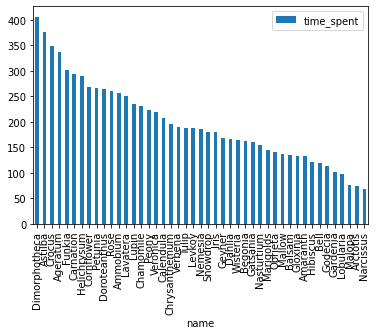

In [19]:
name_stat = data.pivot_table(index='name', values='time_spent') # aggfunc is mean by default
name_stat.sort_values(by = 'time_spent', ascending = False).plot(kind='bar')
plt.show()

The average time drops gradually (which looks fine), with the last chain having average visit time slightly above 50 seconds (which is strange). Since the mean values can be easily distorted by the outliers, let's check the medians.

<a id='raw_data_chain_median_on_visits'></a>

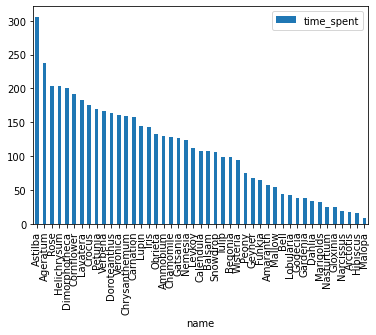

In [20]:
name_stat_median = pd.pivot_table(data=data, index = 'name', values = 'time_spent', aggfunc ='median') # a pivot table with the median
name_stat_median.sort_values(by = 'time_spent', ascending = False).plot(kind = 'bar')
plt.show()

That looks even more disturbing, a third of all the chains have median visit times even around or less than 50 seconds. That means we have a lot of very short visits and what makes the mean look more appropriate are extremely long visit time outliers.

 [Back to Content](#content)

#### A closer look at `time_spent`  <a id='eda_time_spent'></a>
Let's take a closer look at the `time_spent` distribution. Since it is a numerical variable, a better way to visualise it will be plotting a histogram.

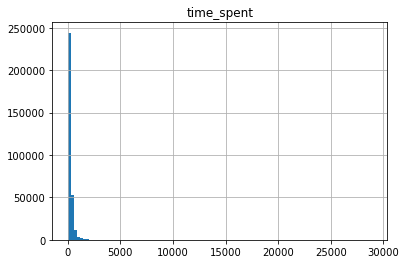

In [21]:
data.hist('time_spent', bins=100)
plt.show()

Looks too high-level, let's shorten the range.

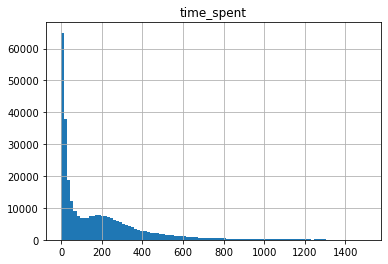

In [22]:
data.hist('time_spent', bins=100, range = (0,1500))
plt.show()

#### Peculiarities that we want to investigate further

Now, we see some details and they actually look suspicious. The data is heavily concentrated around zero values. Let's apply a box plot.

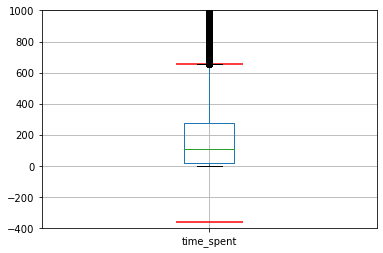

In [23]:
Q1 = data['time_spent'].quantile(0.25)
Q3 = data['time_spent'].quantile(0.75)
IQR = Q3 - Q1
plt.ylim(-400,1000)
data.boxplot('time_spent')
plt.hlines(y=Q1-1.5*IQR, xmin = 0.9, xmax = 1.1, color = 'red') # the theoretical value of the upper whisker
plt.hlines(y=Q3+1.5*IQR, xmin = 0.9, xmax = 1.1, color = 'red') # the theoretical value of the lower whisker
plt.show()

The theoretical value (Q1 - 1.5*IQR) of the lower whisker is so much below zero, that the value plotted is the smallest data point that is greater than or equal to the theoretical value. In addition, we see considerable number of ouliers above the upper whisker. Let's add the numerical characteristics of this distribution.

In [24]:
data.describe()

,time_spent,weekday
count,317104.000000,317104.000000
mean,203.382294,3.084143
std,395.754791,1.990055
min,0.000000,0.000000
25%,19.000000,1.000000
50%,108.000000,3.000000
75%,274.000000,5.000000
max,28925.000000,6.000000


We see that 25% of the visits are 19 seconds and less long: these look more like cars passing by. On the other hand, the maximum visit time is 28925 seconds which is about 8 hours, a work day: which looks like a gas station worker on the shift with his navigation app open all the time. Long visit can be also due to drivers doing something else, buying drinks, food or other supplies, eating, washing the car, sleeping and more. The mean is almost 90% higher than the median, and those extreme outliers are at least one reason for that. So we will have to [get rid of them](#eda_outliers).

So far, we have even more questions:
- What are the reasons for those super-speedy gas station visits?
- What are the reasons for the super-slow ones?
- How these extreme values are distributed among the gas stations / chains, is this characteristic for all of them?
- Do the gas stations with the shortest / longest refueling times differ from the rest of the stations?

Let's identify some gas stations that have the largest 'time_spent' values. 

In [25]:
data.sort_values(by = 'time_spent', ascending = False).head(30)

,date_time,id,time_spent,name,weekday,local_time,date_hour
114797,2018-04-02 15:57:08,3c1e4c52,28925.0,Cornflower,0,2018-04-02 08:57:08,2018-04-02 09:00:00
27147,2018-04-06 18:02:54,4b5f2af5,28519.0,Nemesia,4,2018-04-06 11:02:54,2018-04-06 11:00:00
60547,2018-04-08 10:00:02,cf1ba8a5,28292.0,Cornflower,6,2018-04-08 03:00:02,2018-04-08 03:00:00
19042,2018-04-09 06:42:08,5410e876,23696.0,Cornflower,0,2018-04-08 23:42:08,2018-04-09 00:00:00
118597,2018-04-09 02:50:20,3c1e4c52,21184.0,Cornflower,0,2018-04-08 19:50:20,2018-04-08 20:00:00
118058,2018-04-02 21:13:33,3c1e4c52,20359.0,Cornflower,0,2018-04-02 14:13:33,2018-04-02 14:00:00
114406,2018-04-08 18:37:22,3c1e4c52,19886.0,Cornflower,6,2018-04-08 11:37:22,2018-04-08 12:00:00
132164,2018-04-06 02:07:45,627ea5e3,19445.0,Levkoy,4,2018-04-05 19:07:45,2018-04-05 19:00:00
281360,2018-04-07 04:04:59,d0c0928d,18614.0,Peony,5,2018-04-06 21:04:59,2018-04-06 21:00:00
165326,2018-04-03 09:02:04,3af3bb71,18569.0,Ageratum,1,2018-04-03 02:02:04,2018-04-03 02:00:00


We see that the majority of the cases of very long visit times happen in Cornflower chain, which makes sense since this is the most popular chain. Also, we can see that extremely long fueling visits take place in different stations; though at the same time, the `id` value `3c1e4c52` covers 50% of this subset. <a id='3c1e4c52'> <a/>

Let's apply some slicing to dig dipper into details and get an answer for the following question: how does the distribution of visit times at gas station `3c1e4c52` compare with the overall distribution?

In [26]:
sample = data.query('id=="3c1e4c52"')
total_visits_sample = len(sample)
print('Number of visits at `3c1e4c52`:', total_visits_sample)

Number of visits at `3c1e4c52`: 5814


5817 visits in one week!

Now, let's compare compare the distribution of visit times at gas station `3c1e4c52` with the distribution of visit times for all gas stations.

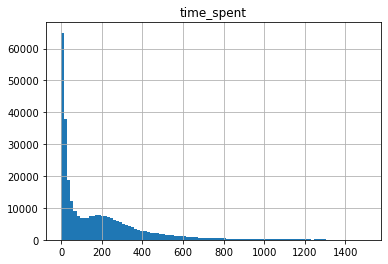

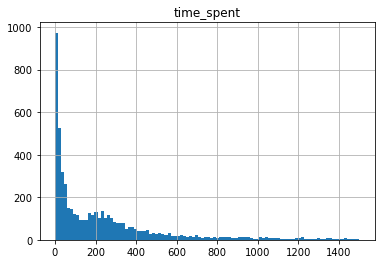

In [27]:
data.hist(column = 'time_spent', bins=100, range = (0,1500 ))
plt.show()

sample.hist(column = 'time_spent', bins=100, range = (0,1500 ))
plt.show()

It turns out that there is nothing special about this particular gas station: both distribution have the same shape - two peaks, around zero and around 200 seconds (the plot for a separate gas station looks less smooth, since there are less data poitns in the `sample` dataset).

 [Back to Content](#content)

### EDA <a id='eda'></a>


#### Determine outliers that can be ignored in our analysis <a id='eda_determing_outliers'></a>

As we mentioned above, those long visit times may be due to drivers doing something else, other than fueling: buying drinks, food or other supplies, eating, washing the car, sleeping and more. Let's assume visits longer than 15 minutes are considered to have additional purposes other than fueling, so we need to filter them. Let's check that they comprise a very small amount of all data.

In [28]:
upper_threshold = 900
data['too_slow']=data['time_spent']>upper_threshold

In [29]:
print('The percentage of visits longer than 900 seconds (15 min) is:', data['too_slow'].mean()*10000//10/10, '%.')

The percentage of visits longer than 900 seconds (15 min) is: 2.4 %.


We can also plot the distribution of slow visits across gas stations.

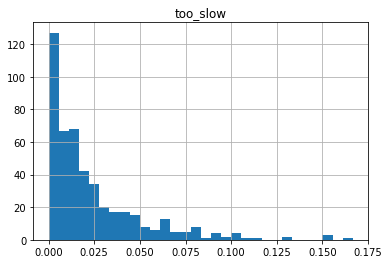

In [30]:
too_slow_stat = data.pivot_table(index='id', values='too_slow')
too_slow_stat.hist(bins=30)
plt.show()

In [31]:
too_slow_stat.describe()

,too_slow
count,471.000000
mean,0.023434
std,0.027530
min,0.000000
25%,0.004994
50%,0.013679
75%,0.032345
max,0.166667


For most of the gas stations, the share of the visits longer than 15 min is below 5% with 50% of them having less than 1.4% of those ultra-long visits; thus, they can be safely deleted.

Let's investigate the ultra-short visits and avter we decide how to deal with them we will remember to update the whole dataset by [filtering the rows](#eda_outliers) with visit times above the `upper_treshold`.

 [Back to Content](#content)


#### Investigating the ultra-short visits  <a id='eda_short_visits'></a>

First, let's estimate what is the share of the short visits in the overall dataset. To this end, we first create a flag variable which will indicated whether the `time_spent` variable value is below 60 seconds or above.

In [32]:
data['too_fast']=data['time_spent']<60
# print(data.head())

The mean of `too_fast` will indicate the proportion of visits that are under 60 seconds.

In [33]:
print(f'The percentage of visits less than 60 seconds (1 min) is:',
      data['too_fast'].mean()*10000//10/10, '%,', sum(data['too_fast']), 'visits.')

The percentage of visits less than 60 seconds (1 min) is: 42.2 %, 133862 visits.


More than 40% of all visits are less than 60 seconds long. A lot. Let's see how they are distributed within this range.

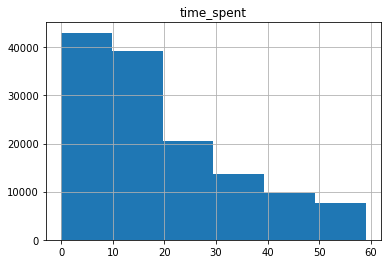

In [34]:
data[data['too_fast']].hist(column='time_spent', bins = 6)
plt.show()

We see a sharp change in the number of visits between those lastet less than 20 seconds and those which lasted 20 seconds and more. Approximately 82 thousands of visits out of 134 had duration less than 20 seconds, more than 60% of all the visits of less than 60 second duration (i.e.~25% of all the visits are less than 20 seconds long). We will investigate them in more detail [later on](#eda_ultra_fast_visits).

 [Back to Content](#content)

#### New questions that arise during exploratory analysis <a id = 'new_eda_questions'> <a/>

Let's try and see at what time of the day the short visits are happening. Since we have seen that that one the most popular gas station has the same distribution of visit times like all the others, we can use `sample` to limit the number of data points for plotting.

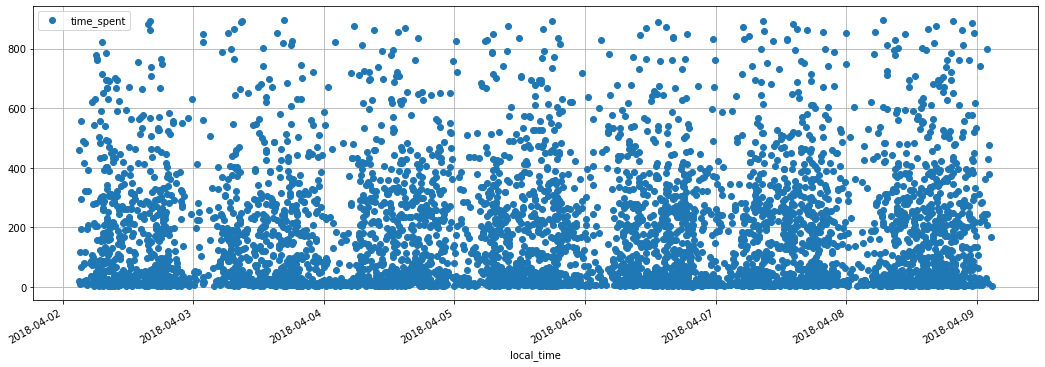

In [35]:
sample.query('time_spent < 900').plot(x='local_time', y='time_spent', style='o', grid = True, figsize = (18,6))
plt.show()

The short visits do not depend on the day time. In addition, we see that the value density decreases at nights, since there are fewer drivers refueling then. However, we have too many points on the graph. To make it clearer, let's group the visits by hours and apply an aggregating function. First, we plot the average visit time per hour.

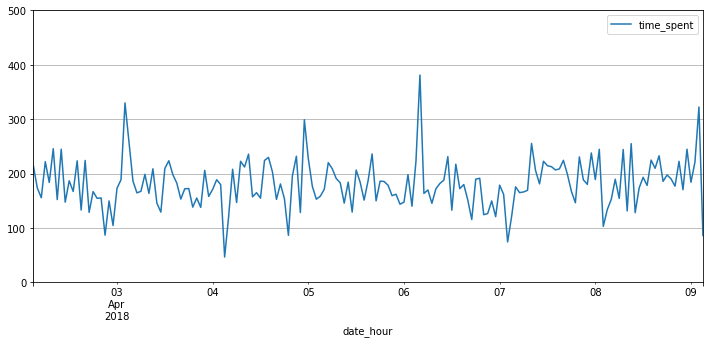

In [36]:
(data
     .query('id == "3c1e4c52" and time_spent < 900')
     .pivot_table(index='date_hour', values='time_spent')
     .plot(grid=True, figsize=(12, 5), ylim = (0,500))
)
plt.show()

Now let's take a look at medians. 

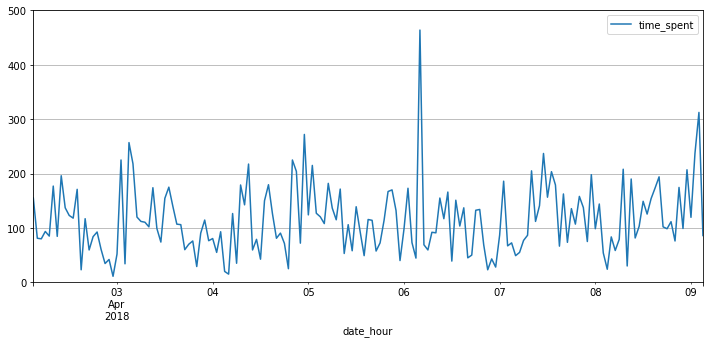

In [37]:
(data
     .query('id == "3c1e4c52" and time_spent < 900')
     .pivot_table(index='date_hour', values='time_spent', aggfunc='median')
     .plot(grid=True, figsize=(12, 5), ylim = (0,500))
)
plt.show()

There is no specific pattern, i.e. there seems to be no particular correlation between refueling time and the time of the day, which makes sense actually. Let's investigate the correlation between the number of visits and the time of the day.

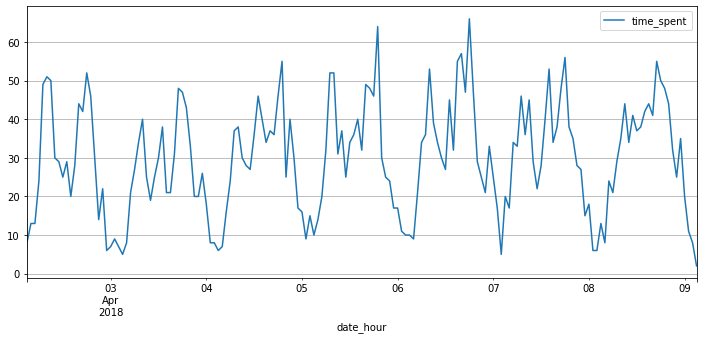

In [38]:
(data
     .query('id == "3c1e4c52" and time_spent < 900')
     .pivot_table(index='date_hour', values='time_spent', aggfunc='count')
     .plot(grid=True, figsize=(12, 5))
)
plt.show()

Here we see the expected pattern that the number of visits diminishes at night and at noon (with local peaks on April 3 and April 4 afternoon).

Next, let's investigate whether those short term visits are a characteristics of all the gas stations. Let's remind, that we have introduced the `too_fast` variable which indicated cases when the `time_spent` value is below 60 seconds. Now we want to use it to calculate the percent of fast visits per gas station. We create a too_fast_stat variable and set it equal to a pivot table that contains the percent of fast visits per gas station.

In [39]:
too_fast_stat = data.pivot_table(index='id',values='too_fast')
print(too_fast_stat.head())

          too_fast
id                
00ca1b70  0.250000
011f7462  0.637489
015eaddd  0.726190
0178ce70  0.211538
018a83ef  0.510269


We observe high variability in the percentage of fast visits per gas station. At our "leader" gas station, for example, we have 35.7% of visits below 60 seconds, which is almost exactly the average share of the fast visits among all the gas stations.

In [40]:
too_fast_stat.query('id == "3c1e4c52"')

,too_fast
id,
3c1e4c52,0.357069


In [41]:
too_fast_stat.describe()

,too_fast
count,471.000000
mean,0.357826
std,0.181525
min,0.000000
25%,0.242242
50%,0.296875
75%,0.412456
max,1.000000


Let's visualize the pivot table by plotting a histogram. <a id = 'share_of_fast_visit'> <a/>

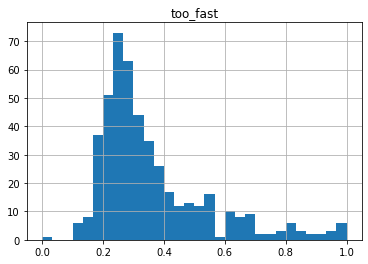

In [42]:
too_fast_stat.hist(bins=30)
plt.show()

Interestingly, there are stations for which the share of fast visits is above 60% and even 100%.

<a id='eda_ultra_fast_visits'></a>

We [remember](#eda_short_visits) that while visits shorter than 60 seconds comprise ~42% of all observations, visits shorter tnan 20 seconds comprise ~25% of all observations and there is a sharp decline in the number of visits with the duration between 20 and 60 seconds compared to those shorter than 20 seconds. Let's make a zoom in into "ultra-fast" visits:

In [43]:
data['ultra_fast']=data['time_spent']<20 #a flag variable which indicates whether the visit was < than 20 seconds long
ultra_fast_stat = data.pivot_table(index='id',values='ultra_fast') # share of less < 20 seconds visits by station
print(too_fast_stat.head())

          too_fast
id                
00ca1b70  0.250000
011f7462  0.637489
015eaddd  0.726190
0178ce70  0.211538
018a83ef  0.510269


In [44]:
ultra_fast_stat.query('id == "3c1e4c52"') # share of less < 20 seconds visits for station "3c1e4c52"

,ultra_fast
id,
3c1e4c52,0.19969


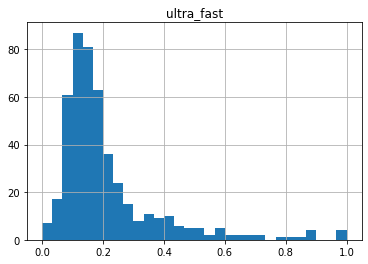

In [45]:
ultra_fast_stat.hist(bins=30)
plt.show()

In [46]:
ultra_fast_stat.describe()

,ultra_fast
count,471.000000
mean,0.210210
std,0.166051
min,0.000000
25%,0.117503
50%,0.160000
75%,0.234530
max,1.000000


Different gas stations have different share of such visits relative to total visits with appr. 20% on average, while 50% have up to 16% of them and 75% of the stations have up to 23.5% of such visits.

Let's check how many visits in total there were at the stations with 50% or more `ultra_fast` visits. First, we will use `ultra_fast_stat` to obtain station IDs that conform to this condition. Then, we will use these IDs to filter data. 

In [47]:
nonconform_ids = ultra_fast_stat.query('ultra_fast >= 0.5')
print(len(nonconform_ids))

31


Visits at 31 gas stations (out of 471) have 50% and more share of those lasting less than 20 seconds.

For a more complete picture, let's take a look at the relationships between average time, average number of visits that are too short, average number of visits that are ultra short, and average number of visits that are too long.  <a id = 'too_fast_to_keep'> <a/>

In [48]:
station_corr = data.pivot_table(index='id', values = ['time_spent', 'too_fast', 'ultra_fast', 'too_slow'])

            time_spent  too_fast  too_slow  ultra_fast
time_spent    1.000000 -0.640658  0.816549   -0.560597
too_fast     -0.640658  1.000000 -0.280563    0.876199
too_slow      0.816549 -0.280563  1.000000   -0.262170
ultra_fast   -0.560597  0.876199 -0.262170    1.000000


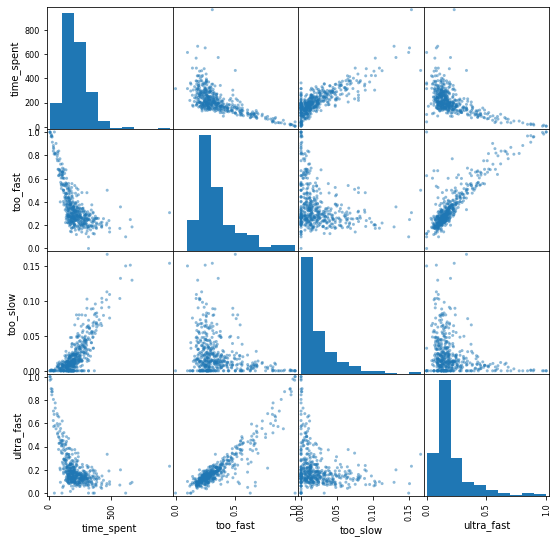

In [49]:
print(station_corr.corr())
pd.plotting.scatter_matrix(station_corr, figsize=(9, 9)) 
plt.show()

Based on the scatter matrix, there is a nearly direct correlation between mean visit time and the share of `too_fast` visits when it is above 60% and between mean visit time and the share of `ultra_fast` visits when it is above 50%. In addition, we can see to what degree the mean visit time is affected by `too_slow` visits (essentially highly affected with the correlation of more than 0.8); thus, taking the median as opposed to the mean is the right thing to do for this dataset.

The share of the visits at stations with 50% and more `ultra_fast` visits relative to total visits less than 15 min long:

In [50]:
print(len(data.query('time_spent < 900 and id in @nonconform_ids.index'))/len(data))

0.12848781472324536


The share of the visits at sations with 50% and more `ultra_fast` visits relative to total visits in the original dataset:

In [51]:
print(len(data.query('id in @nonconform_ids.index'))/len(data))

0.12897976689035773


Thus, we will lose appr. 13% of the original data as a measure to improve its overall quality, if we decide to proceed with the 20 seconds lower threshold.

Note: interestingly, there seems to be a constant level of `ultra_fast` visits at nights; the hourly graph of the `ultra_fast` visits at stations for which their share is 50% and more shows that at least 50 of such visits are happening on the hourly basis between during the night hours (3 a.m. to 5 a.m. "usually").

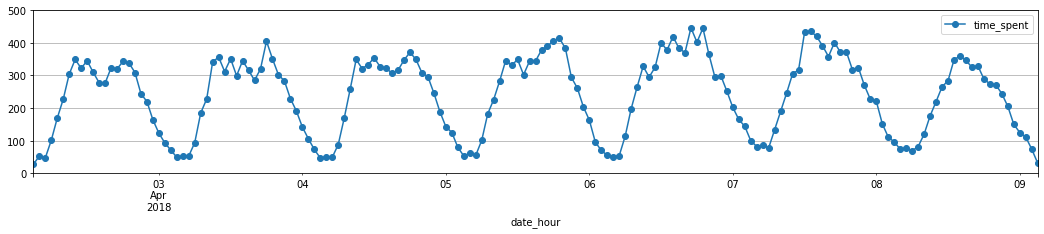

In [52]:
(data
     .query('time_spent < 900 and id in @nonconform_ids.index')
     .pivot_table(index='date_hour', values='time_spent', aggfunc = 'count')
     .plot(grid=True, figsize=(18, 3), style = 'o-', ylim = (0,500))
)
plt.show()

The share of the visits at stations with 60% and more `too_fast` visits relative to total visits less than 15 min long:

In [53]:
nonconform_ids_too = too_fast_stat.query('too_fast >= 0.6')
print(len(data.query('time_spent < 900 and id in @nonconform_ids_too.index'))/len(data))

0.24736679449013574


Thus, we will drop appr. 25% of the original data as a measure to improve its overall quality, if we decide get rid of stations with more than 60% of less than 60 seconds long visits.

 [Back to Content](#content)

#### Side comment: Communicating the EDA results so that action can be taken <a id = 'communication'> <a/>

It looks like we have to get back to the client to clarify what is an issue with the original dataset, maybe with the algorithm for exporting data, or to discover that there's simply a factor we overlooked, like closed gas stations and or drivers just passing by without entering the station, and there's no issue after all. Let's pick up the most outstanding example of the error.

In [54]:
print(too_fast_stat.sort_values('too_fast', ascending=False).head()) 

          too_fast
id                
c96c61cd  1.000000
c527c306  1.000000
5372547e  1.000000
792b6ded  0.996253
bd1d0bb0  0.982044


Let's see how many visits there were at these gas stations.

In [55]:
data.query('id == "c96c61cd"')['too_slow'].count() 

1

In [56]:
data.query('id == "c527c306"')['too_slow'].count() 

2

In [57]:
data.query('id == "5372547e"')['too_slow'].count() 

1

In [58]:
data.query('id == "792b6ded"')['too_slow'].count() 

4270

The first three cases are artefacts, since they had 1 to 2 visits. But `792b6ded` station had 4270 visits and 99.62% of them lasted less than 60 seconds. Let's take a closer look at the basic statistics.

In [59]:
data.query('id == "792b6ded"').describe() 

,time_spent,weekday
count,4270.000000,4270.000000
mean,5.448712,3.090398
std,8.597126,1.898274
min,0.000000,0.000000
25%,2.000000,1.000000
50%,3.000000,3.000000
75%,5.000000,5.000000
max,228.000000,6.000000


75% of visits below 5 seconds.

This gas station can serve as an example for the brainstorming with the client.

 [Back to Content](#content)

#### Conclusions on the need to clean the original dataset

*Until we have updates from the client side*, we proceed with cutting of the `too_slow` and `ultra_fast` visits. We have seen that the [former](#eda_determing_outliers) comprise ~2.4% of all observations and for most of the gas stations, the share of the visits longer than 15 min is below 5%; they seem to be composed of several operations, in addition to refueling (e.g. shopping, eating, etc.); thus, we can safely remove them from our analysis.

The [latter](#eda_ultra_fast_visits) comprise appr. 25% of all observations, if we choose visits shorter than 20 seconds as `ultra_fast` (while waiting for additional details from the client, we assume that you still can fill a couple of liters in 20 seconds as well, at least if you have an automatic refueling gauge on the gas tank); they are evenly distributed along the time of the day and different gas stations have different share of such visits relative to total visits (appr. 20% on average, while 50% have up to 16% of them and 75% of the stations have up to 23.5% of such visits).

Thus, the problem we are dealing with:
- There are visits in our dataset that are abnormally long;
- These extreme durations probably reflect drivers who stop for additional arrangements, other then refueling;
- ~42% of all visits are shorter than 60 seconds;
- There are gas stations in our dataset where 60% and more of visits are shorter than 60 seconds;
- For those stations, the average visit time at the gas station is directly affected by the share of such visits; it cannot be asigned to a refueling operation in any case.

From here we can apply the following rules:

**1**. More than 15 min long visits are excluded from the analysis.

**2**. Gas stations where 60% or more of visits are shorter than 60 seconds are excluded from the analysis.

**3**. For the resulting dataset, visits shorter than 60 seconds are excluded from the analysis as well.

#### Getting rid of gas stations with 50% and more share of visits lasting less than 20 seconds <a id='eda_nonconform_ids_filter|'></a>

In [60]:
conform_ids = too_fast_stat.query('too_fast < 0.6')
filtered_data = data.query('id in @conform_ids.index')

#### Getting rid of outliers in `time_spent`  <a id='eda_outliers'></a>

In [61]:
filtered_data=filtered_data.query('time_spent >= 60 and time_spent <=900')

In [62]:
print(len(filtered_data))
print(len(filtered_data)/len(data))

157301
0.49605492204450274


Thus, we are left with ~49.6% of the initial dataset.


 [Back to Content](#content)

 ## Stage 4. Estimating the median visit time per chain <a id='estimates'></a>

####  The impact of high proportions of abnormally short visits on the estimates

The ultimate goal of this project is to identify chains where drivers experience long visit times, but before we proceed, we will check to what degree our estimates will be impacted by proportions of abnormal visits, more specifically, we want to know whether the remaining data provides more realistic estimates. 

Let's start with the medians for individual gas stations:

In [63]:
data_stat = data.pivot_table(index='id', values='time_spent', aggfunc = 'median')
filtered_data_stat = filtered_data.pivot_table(index='id', values='time_spent', aggfunc = 'median')

Let's check that we do have lower correlation between our estimates and the share of `too_fast` visits now. To this end, we will add the column of median visit time values from `data_stat` and `filtered_data_stat` to our `station_corr` dataframe, namely its `too_fast` column, and print out the correlation matrix and the scatter matrix again.

In [64]:
# dropping mean `time_spent` and reordering the columns according to their logic
station_corr = station_corr[['too_fast']]

In [65]:
# the Series with station-wise median `time_spent` from the raw dataset
raw_med_time_spent = data_stat['time_spent']
# the Series with station-wise median `time_spent` from the cleaned dataset
filtered_med_time_spent = filtered_data_stat['time_spent']

# inserting the two Series of raw and filteres median estimates
station_corr['raw_med_time_spent'] = data_stat['time_spent']
station_corr['filtered_med_time_spent'] = filtered_data_stat['time_spent']

                         too_fast  raw_med_time_spent  filtered_med_time_spent
too_fast                 1.000000           -0.799696                -0.357460
raw_med_time_spent      -0.799696            1.000000                 0.832436
filtered_med_time_spent -0.357460            0.832436                 1.000000


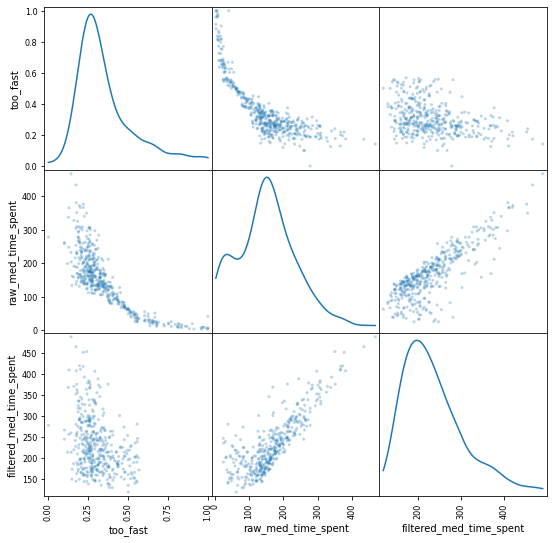

In [66]:
print(station_corr.corr())
axes = pd.plotting.scatter_matrix(station_corr, alpha=0.3, figsize=(9,9), diagonal='kde')
# kernel density estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable

# formatting the yaxis for the `too_fast` variable - basic printing results in to many floating signs
new_labels = [round(float(i.get_text()), 2) for i in axes[0,0].get_yticklabels()]
axes[0,0].set_yticklabels(new_labels)

plt.show()

<a id='less_correlation'> <a/>

Now, `filtered_med_time_spent` has much lower correlation with the share of `too_fast` visits than `raw_med_time_spent`, which is also clearly illustrated by the scatter matrix (see the two scatter plots in the first row); thus, we have reduced the impact of suspicious data on the final result. The kernel density estimation (KDE) plots point at a more lognormal distibution for `filtered_med_time_spent`, let's have a detailed look at the two distributions:

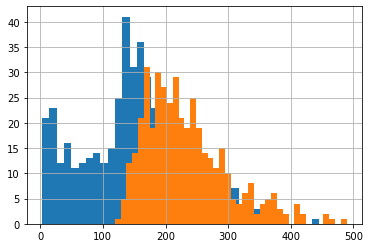

In [67]:
data_stat['time_spent'].hist(bins=40)
filtered_data_stat['time_spent'].hist(bins=40)
plt.show()

One can easily see that there is a meaningful difference in median times due to clean up of some gas stations and of the `too_fast` visits in general; most gas stations have median `time_spent` between 120 and 300 seconds. i.e. between 2 and 5 minutes.

#### Finally - estimates! <a id='finally_estimates'> <a/>

To have a more robust estimate, which is less sensitive to problems with individual gas stations, whether physical or on the data extraction level, of how much time drivers typically spend at gas stations of a particular chain, we will apply the aggregate median function to the medians for individual gas stations to calculate the median for each chain.

Before we proceed, we need to account for high variability of individual estimates when based on small samples: to proceed with aggregating medians by chains, we need to exclude gas stations with very low visit counts. To do this, we need to know, for every gas station, the chain it belongs to and its total number of visits. Building a pivot table with `id`'s as indices and calling first or last value on column `name` for each group of IDs will provide chain names for our gas stations:

In [68]:
id_name = filtered_data.pivot_table(index = 'id', values = 'name', aggfunc=['first', 'count'])
id_name.columns = ['name','count']

Let's take a look at the distribution of visits across gas stations within each chain:

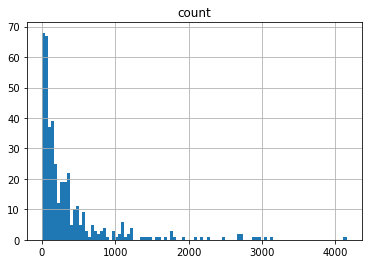

In [69]:
id_name.hist(bins=100)
plt.show()

We will drop stations which have less than 30 visits over the 7-day period covered by the data at hand. Note: so far, we are dealing with nonnormal distributions of discrete-count values and we've been working with medians so far; thus, this number has nothing to do with the minimum sample size requirement of 30 for the Central Limit Theorem to apply; we essentially are comparing the medians of the number of visits at different sites / days of the week and for hypothesis testing or confidence interval estimation we would consider to apply the nonparametric Mann-Whitney test; we will assume a regular gas station has at least 2 visit per hour excluding 3 "dead" night hours, which makes appr. 40 daily visits and 280 visits per week (we remember that, according to our estimates, the initial dataset cover about 10% of all visits to gas stations). 

We join `id_name` table with `filtered_data_stat` to receive chain-wise statistics with station median visit durations, `id_name_stat` <a id='chain_station_median'></a>:

In [70]:
id_name_stat = id_name.merge(filtered_data_stat, on = 'id')
id_name_stat.columns = ['name', 'visits', 'median_time_spent'] # rename the columns for more convenience
id_name_stat.head()

,name,visits,median_time_spent
id,,,
00ca1b70,Veronica,131,166.0
0178ce70,Cornflower,164,234.5
018a83ef,Calendula,294,198.5
01abf4e9,Gatsania,29,174.0
030a9067,Bell,228,135.5


Now, we calculate the chain medians without dropping stations with less than 30 visits by aggregating the station medians (on filtered data):

In [71]:
chain_stat = id_name_stat.pivot_table(index = 'name', values = 'median_time_spent', aggfunc=['median', 'count'])
chain_stat.columns = ['station_median_time', 'station_qty']
chain_stat.head()

,station_median_time,station_qty
name,,
Ageratum,285.00,6
Amaranth,167.50,8
Ammobium,170.00,5
Arctotis,183.75,4
Astilba,389.00,9


Let's take a look at TOP5 and compare it with a plain calculation of chain medians by direct grouping of visits by chains on filtered data:

In [72]:
chain_stat.sort_values(by ='station_median_time', ascending=False).head()

,station_median_time,station_qty
name,,
Astilba,389.0,9
Helichrysum,336.0,1
Rose,313.5,26
Petunia,301.5,1
Dahlia,289.0,9


In [73]:
# chain median on visits - filtered data
filtered_data_name_stat = filtered_data.pivot_table(index='name', values='time_spent', aggfunc = 'median')
filtered_data_name_stat.sort_values(by ='time_spent', ascending=False).head()
#filtered_data_name_stat.sort_values(by ='time_spent', ascending=False).plot(kind='bar')
#plt.show()

,time_spent
name,
Astilba,415.0
Helichrysum,336.0
Rose,312.5
Ageratum,306.0
Petunia,301.5


Note, in addition to differences in the values, the chain named "Dahlia" does not even appear in TOP5 ranking based on the direct aggregations of visits, which includes "Ageratum" instead. We can also compare the last result to plain calculation of chain medians by direct grouping of visits by chains on raw data:

In [74]:
#chain median on visits - raw data
name_stat_median.sort_values(by ='time_spent', ascending=False).head()

,time_spent
name,
Astilba,306.0
Ageratum,238.0
Rose,204.0
Helichrysum,203.0
Dimorphotheca,200.0


The raw-data dataset gave even more different estimate for the top five chains; one can estimate the degree to which this straight-forward calculation could mislead prioritization of the effort, which in turn would result in sub-optimal investment into further collaboration development. Note, two chains from the final ranking does not even appear in TOP5 ranking based on the raw-data.

To make all three results comparable, let's built one table that will show, for each chain, median visit time estimated using the raw data and median visit time estimated using the filtered data - trough a direct calculation by visits and through station medians.

In [75]:
name_stat_median['visit_median_time'] = filtered_data_name_stat['time_spent']

In [76]:
name_stat_median_final = name_stat_median.join(chain_stat)
name_stat_median_final.rename(columns = {'time_spent':'visit_median_time_raw'}, inplace = True)

In [77]:
name_stat_median_final.sort_values(by ='station_median_time', ascending=False)

,visit_median_time_raw,visit_median_time,station_median_time,station_qty
name,,,,
Astilba,306.0,415.0,389.00,9.0
Helichrysum,203.0,336.0,336.00,1.0
Rose,204.0,312.5,313.50,26.0
Petunia,169.0,301.5,301.50,1.0
Dahlia,33.0,278.0,289.00,9.0
Ageratum,238.0,306.0,285.00,6.0
Lavatera,183.0,279.0,273.00,11.0
Crocus,176.0,257.5,257.50,1.0
Nasturtium,25.0,247.0,247.00,1.0


The change in the estimates is tremendous for every chain.

Now, let's make a quick check how the distribution of stations look like by the number of visits. First, we count the stations by number of visits. Then, after joining `id_name` with `filtered_data_stats`, we will check how median visit times are distributed in less visited gas stations.

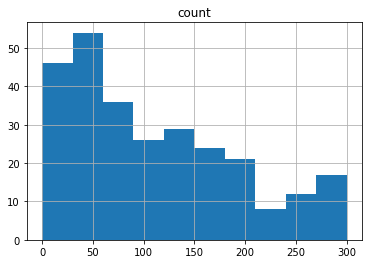

In [78]:
id_name.hist(range=(0,300)) # check the distribution for small number of total visits
plt.show()

Finally, we will check how median visit times are distributed in less visited gas stations.

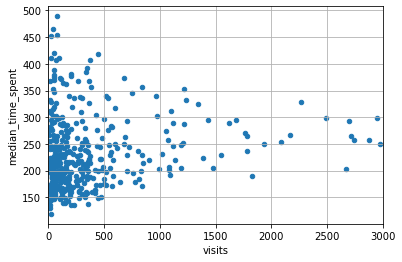

In [79]:
id_name_stat.plot(kind='scatter', x = 'visits', y = 'median_time_spent', xlim = (0,3000), grid = True)
plt.show()

 We use `alpha` parameter and change the value of `range` parameter to make the graph more understandable. <a id = 'small_num_visits'> <a/>

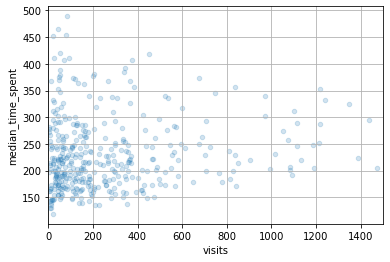

In [80]:
id_name_stat.plot(kind='scatter', x = 'visits', y = 'median_time_spent', xlim = (0,1500), grid = True, alpha=0.2)
plt.show()

We see that with less visits the dispersion of median visit times grows, i.e. the estimate of the median visit time is less robust for statuins with small number od visits.

Now, let's recalculate our chain medians while dropping stations with 30 visits and less (again, we aggregate station medians into chain medians which results in a more robust estimate). In addition, we count the number of gas stations left in each chain.

In [81]:
chain_stat = id_name_stat.query('visits  > 30').pivot_table(index = 'name', values = 'median_time_spent', aggfunc=['median', 'count'])
chain_stat.columns = ['chain_median_visit_time', 'station_qty']
chain_stat.head()

,chain_median_visit_time,station_qty
name,,
Ageratum,304.50,3
Amaranth,167.50,6
Ammobium,177.00,4
Arctotis,183.75,4
Astilba,427.25,4


We will group all the chains with less than 10 stations left in them, since we assume the client will not be interested to invest efforts in small chains, at least not as the first priority. We will sort the chains by the final median value of visit duration.

Let's take a look at the distribution of number of gas stations across chains:

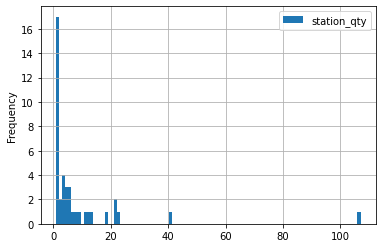

In [82]:
chain_stat.plot(y = 'station_qty', kind = 'hist', bins = 100, grid = True) 
plt.show()

There are chains with 20 and more stations, but there are also many small chains. To make the graphical representation more convenient, we will group the smaller once (those with 10 stations and less) into separate group.

In [83]:
# build the list of chains with more than 10 stations
name_stat_final_10 = chain_stat.query('station_qty>=10').sort_values(by ='chain_median_visit_time', ascending=False)

Let's take a look at the leader board, chains with more than 10 stations:

In [84]:
name_stat_final_10

,chain_median_visit_time,station_qty
name,,
Rose,335.5,18
Lavatera,273.0,11
Cornflower,246.5,107
Calendula,230.0,41
Nemesia,223.0,22
Lupin,200.0,13
Geyher,191.0,12
Mallow,179.0,23
Bell,159.5,22


Now we can extract the chains with less than 10 stations into separate group "Others"; we will repeat the calculation of the median by chains based on station median, while treating "Others" as one big chain. To this end, we should add a column, let's call it `group_name`, to our `filtered_data` dataset:

In [85]:
filtered_data_stat['group_name'] = id_name['name'].where(id_name['name'].isin(name_stat_final_10.index), 'Others')
filtered_data_stat.head()

,time_spent,group_name
id,,
00ca1b70,166.0,Others
0178ce70,234.5,Cornflower
018a83ef,198.5,Calendula
01abf4e9,174.0,Others
030a9067,135.5,Bell


In [86]:
id_name_stat = id_name.merge(filtered_data_stat, on = 'id')
id_name_stat.columns = ['name', 'visits', 'median_time_spent', 'chain_group'] # rename the columns for more convenience
id_name_stat.head(1)

,name,visits,median_time_spent,chain_group
id,,,,
00ca1b70,Veronica,131,166.0,Others


Let's ensure that the distributions of visit times are roughly similar and we are right comparing estimates across chains. To this end, we will slice `id_name_stat` by `chain_group` and plot a histogram of `median_time_spent` for every slice:

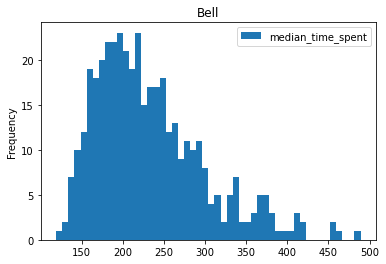

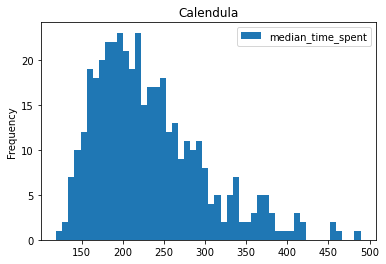

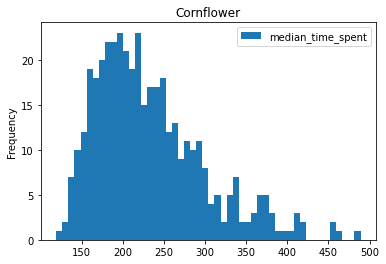

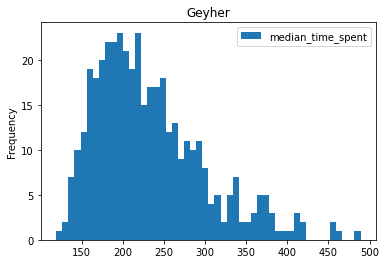

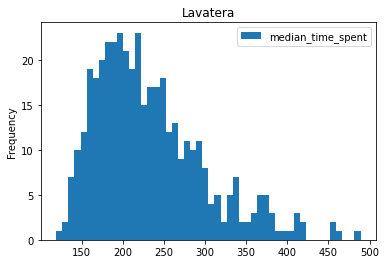

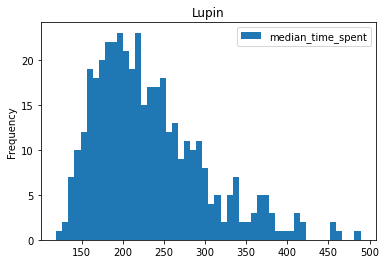

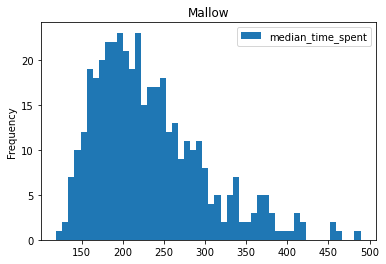

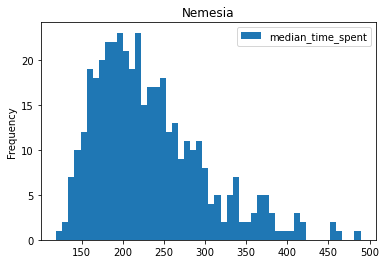

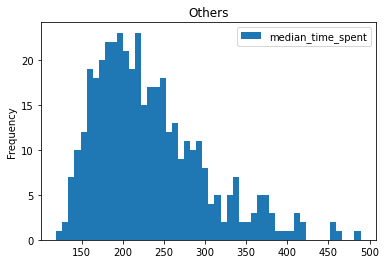

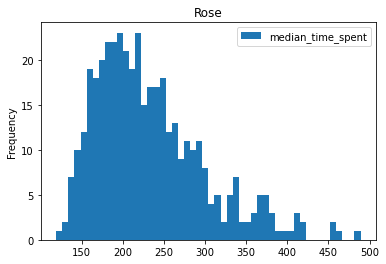

In [87]:
for name, chain_group in id_name_stat.groupby('chain_group'):
    id_name_stat.plot(y = 'median_time_spent', kind = 'hist', bins = 50, title = name)

The distributions look very similar; thus, we can actually compare the estimates between them. Now we can recalculate our [chain medians](#chain_station_median):

In [88]:
chain_stat = id_name_stat.query('visits  > 30').pivot_table(index = 'chain_group',
                                                            values = 'median_time_spent', aggfunc=['median', 'count'])
chain_stat.columns = ['chain_median_visit_time', 'station_qty']

Let's compare where our artificial chain "Others" is placed on the leader board and illustrate the final ranking:

In [89]:
chain_stat.sort_values(by ='chain_median_visit_time', ascending=False)

,chain_median_visit_time,station_qty
chain_group,,
Rose,335.50,18
Lavatera,273.00,11
Cornflower,246.50,107
Calendula,230.00,41
Nemesia,223.00,22
Lupin,200.00,13
Others,199.25,100
Geyher,191.00,12
Mallow,179.00,23


<a id = 'final_graph'> <a/>

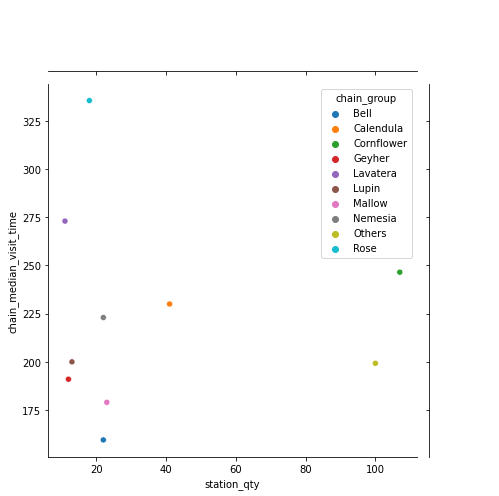

In [90]:
sns.jointplot(data=chain_stat,
                 x="station_qty", y="chain_median_visit_time", hue = 'chain_group', size = 7)

plt.show()

According to the estimates above, Rose, Calendula, Nemesia and Cornflower seem to be the first chains to partner with them, Lavatera may be as well, though it has only 11 stations, at least in the final dataset. It can make less sense to turn to the chains which have tha same or lower median visit durations than all the other chains as aggregate.

 [Back to Content](#content)

 ## Stage 5. Summary and conclusions <a id='conclusions'></a>


The client, a navigation app, asked to find out more about customer behavior at gas stations, specifically, they wanted to figure out how much time, on average, drivers spend filling up at each gas station chain.

We were provided with data on individual gas station visits. The dataset covers the following variables:

- `name` — the encrypted name of each gas station chain; each name has been replaced with that of a flower
- `id` — a unique code for each particular gas station
- `date_time` — the time the driver arrived at the gas station, in ISO format;
- `time_spent` — the amount of time spent at the gas station in seconds.

The data covered 317104 data points within the week of April 2, 2018 to April 9, 2018 on 45 gas chains, with 471 stations in total, roughly 100 visits per gas station per day, which we estimated as comprising around 10% of the total refueling traffic (those are customers with a navigation app open as the source of data). The data indicated that two chains grabbed more than 50% of the market, with 5 more chains taking additional 35%.

The data did not contain missing values, only `date_time` variable was of the string type with dates in ISO UTC format, so we [took care of the date and time relevant issues](#preprocessing) straight away:
- converted this column into datetime type;
- added three columns - `weekday`, `local_time`, `date_hour`, to find out how gas station visiting times depend on the days of the week and on the time of the day.


After completing preprocessing of the datetime data, we started our exploratory analysis directly from looking at `time_spent` variable. We immediately came up with [two strange facts](#eda):
- the average visit time drops gradually (which looked fine), with the last chain having average visit time slightly above 50 seconds (which was strange);
- when medians were checked, a third of all the chains had median visit times even around or less than 50 seconds.

While taking a [closer look at `time_spent`](#eda_time_spent) variable we found massive concentration of near-zero visiting times (appr. 25% of all visits had `time_spent` value below 20 seconds; more than 42% lasted less than 60 seconds. In addition, appr. 2.4% of the visits had duration above 15 minutes with some visits ending up being 8 hour long. Both too short and too long visit times took place at various stations.

Speculating on the reasons of the latter fact, we suggested that hour long visits can be attributed to gas station workers on the shift with navigation app open all the time and drivers doing something else, e.g., buying drinks, food or other supplies, eating, washing the car, sleeping and more. The mean was almost 90% higher than the median, and those extreme outliers are at least one reason for that. With regard to the short visits, those which were 19 seconds and less long can be cars passing by. In genreal, visits below 60 seconds, look suspicious and after some short analysis we built [a case to communicate the issue](#communication) to the client to get more details on possible reasons.

Next, we took [a closer look at the gas station with most of the ultra-long visits](#3c1e4c52) and did not find any differences in the shape of the distribution of the `time_spent` variable relative to the rest of the sample. We assumed, that a visit aiming refueling should last less than 15 minutes; after checking the share of visits longer than 15 minutes, we found that for the majority of gas stations the overall [share of long visits did not exceed 5%](#eda_determing_outliers), with 50% of them having less than 1.4% of long visits. After checking that visits longer than 15 minutes can be safely dropped, we proceeded to [investigating the too short and ultra-short visits](#new_eda_questions), i.e. those shorter than 60 and 20 seconds, correspondingly.

The amount of short visits did not depend on the day time (the overall number of visits diminished at night and during the afternoon as expected). We found no particular correlation between visiting time and the time of the day, which makes sense actually. By calculating the [percentage of fast visits per gas station](#share_of_fast_visit), we found that there were stations with more than 60% of visits shorter than 60 seconds and some of them had 100% of short visits. Different gas stations had various shares of visits less than 20 seconds long with appr. 20% on average, while 50% had up to 16% of them and 75% of the stations had up to 23.5% of such visits. Specifically,  at 31 gas stations (out of 471) 50% and more of all visits were shorter than 20 seconds.

Based on the scatter matrix, we found a nearly direct correlation between mean visit time and the share of visits shorter than 60 seconds when this share is above 60%. Thus, the conclusion was to drop those visits all together. We estimated the "losses" and found that [the share of visit below 60 seconds at stations where 60% and more of the visits are this long](#too_fast_to_keep) is appr. 25% of the original dataset.

To sum up, the problem we were dealing with in our dataset:
- There were visits in our dataset that are abnormally long;
- These extreme durations probably reflect drivers who stop for additional arrangements, other then refueling;
- ~42% of all visits were shorter than 60 seconds, appr. 25% shorter than 20 seconds;
- There were gas stations in our dataset where 60% and more of visits were shorter than 60 seconds;
- For those stations, the average visit time at the gas station is directly affected by the share of such visits; it cannot be asigned to a refueling operation in any case.

To clean the data (until we have additional inputs from the client), we applied three rules:
- More than 15 min long visits are excluded from the analysis.
- Gas stations where 60% or more of visits are shorter than 60 seconds are excluded from the analysis.
- For the resulting dataset, visits shorter than 60 seconds are excluded from the analysis.
 
Before moving to the [estimates](#estimates), we checked whether they could be still impacted by proportions of abnormal visits. We found that we [significantly reduced the correlation](#less_correlation) between median `time_spent` by gas station with the visits shorter than 60 seconds in the filtered dataset compared to the raw dataset. A meaningful difference in median times appeared due to clean up of some gas stations and of the `too_fast` visits in general; most gas stations have median `time_spent` between 120 and 300 seconds. i.e. between 2 and 5 minutes.

To have a more [robust estimate](#finally_estimates) (which would be less sensitive to problems with individual gas stations, whether physical or on the data extraction level) of how much time drivers typically spend at gas stations of a particular chain, we applied the aggregate median function to the medians for individual gas stations to calculate the median for each chain. We checked and found that [with less visits the dispersion of median visit times grows](#small_num_visits), i.e. the estimate of the median visit time is less robust for stations with small number of visits; therefore, to account for high variability of individual estimates when based on small samples, we dropped gas stations with less than 30 visits for the 7-day period under investigation. We also treated chains with 10 and less gas stations as one group (we called it "Others"), assuming that the client will be less interested in investing their effort into those chains at this stage of the deployment, and got final estimates for 10 chains including "Others". The distributions of visit times were roughly similar, so the estimates are comparable across the chains.

**Finally, the main finding was that chains called Rose, Calendula, Nemesia and Cornflower seemed to be the first chains to partner with them with median refueling time above 200 seconds, Lavatera may be as well, though it had only 11 stations, at least in the final dataset. It can make less sense to turn to the chains which have the same or lower median visit duration (200 seconds) than all the other chains as aggregate. We [illustrated this conclusion with a graph](#final_graph) showing the median refueling time and the number of gas stations by chain.**

 [Back to Content](#content)